In [1]:
import numpy as np
# import pandas as pd
from matplotlib import pyplot as plt
import time
import torch
from pymoo.indicators.hv import HV
from pymoo.visualization.scatter import Scatter
from metrics import mean_Euclidean_dist
from pymoo.config import Config
Config.warnings['not_compiled'] = False
from partitioning import sampling_vector_randomly, sampling_vector_evenly
from pymoo.util.ref_dirs import get_reference_directions
from problem import get_problem
from pymoo.problems import get_problem as get_problem2

In [2]:
problem_name = "DTLZ2"
n_sample = 50

pref_vec_test = get_reference_directions("das-dennis", 3, n_partitions=50)
truth_front =  np.transpose(get_problem2("dtlz2").pareto_front(pref_vec_test))

pref_vec_test = sampling_vector_evenly(3, 300)
f_truth =  get_problem2("dtlz2").pareto_front(pref_vec_test)

n_sample = 50
r = 1
u = np.linspace(0, np.pi/2, n_sample)
v = np.linspace(0, np.pi/2, n_sample)
a = np.expand_dims(r*np.outer(np.cos(u), np.sin(v)).flatten(), axis=1)
b = np.expand_dims(r*np.outer(np.sin(u), np.sin(v)).flatten(), axis=1)
c = np.expand_dims(r*np.outer(np.ones(np.size(u)), np.cos(v)).flatten(), axis=1)
front_truth =  np.hstack((a,b,c))

In [3]:
def plot_front(problem_name = "DTLZ2", n_dim = 5, plot_type = 0, suffix = "", title = ""):
    log_dir = f"weight/ablation_{problem_name}_PSL"
    index = [16, 20, 24, 28, 32, 36, 40, 44, 48]
    y_value = np.load(f"{log_dir}/y_{problem_name}_{n_dim}{suffix}.npy")
    font_size = 10
    scatter_size = 10
    front_value = np.load(f"{log_dir}/front_{problem_name}_{n_dim}{suffix}.npy")
    
    fig, axs = plt.subplots(figsize = (10, 10), ncols = int(len(index)/3), nrows=3, layout="constrained", subplot_kw=dict(projection='3d'))
    axs = axs.flatten()
    
    for i, ind in enumerate(index):   
        if plot_type == 1:
            num_eval = 5*ind+180
        else:
            ind += 40
            num_eval = 5*ind-20
            
        y_truth, y_hat = y_value[ind - 1], front_value[ind - 1]
        euclidean_score = mean_Euclidean_dist(f_truth, y_hat)
        axs[i].view_init(elev=10., azim=30)
        axs[i].scatter(truth_front[0], truth_front[1], truth_front[2], color="green", s=0.1, label="DTLZ2 Pareto Front")
        axs[i].scatter(y_hat[:, 0], y_hat[:, 1], y_hat[:, 2], s=scatter_size , zorder=2, color = "blue", label = "Pareto Solutions computed by Surrogate Model")
        axs[i].set_title(f"Number of evaluations: {num_eval}\nMean Euclidean Distance: {round(euclidean_score, 6)}", fontsize=font_size, y=0.96)
        axs[i].set_xlabel(r'$f_1(x)$', color="blue")
        axs[i].set_ylabel(r'$f_2(x)$', color="blue")
        axs[i].set_zlabel(r'$f_3(x)$', rotation=0, color="blue")
        axs[i].zaxis.labelpad=-0.7
    fig.suptitle(f"{title}",fontweight="bold",fontsize=font_size + 5)
    fig.legend(*axs[1].get_legend_handles_labels(), bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=2, fontsize=font_size)
    fig.savefig(f"visualization_plot/Front_{problem_name}-{title}.pdf", bbox_inches='tight')
    plt.show()

In [4]:
def Mean_Euclidean_distance_ablation(list_id, label_id, log_dir, problem_name = "DTLZ2", n_dim = 6, title = ""):
    
    for i, ids in enumerate(list_id):
        MED_score = []
        front_score = np.load(f"{log_dir}/front_{problem_name}_{n_dim}_Co-PSL_{ids}.npy")
        front_score = front_score[-20:]
        
        for j in range(front_score.shape[0]):
            MED_score.append(mean_Euclidean_dist(f_truth, front_score[j]))
        
        plt.plot(MED_score, color = color_code[i], label = label_id[i])
    plt.ylabel("Mean Euclidean Score")
    plt.xlabel("Co-PSL Expensive Evaluations")
    plt.xticks([0, 4, 9, 14, 19], [220, 270, 320, 370, 420])
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncols=2)
    plt.savefig(f"visualization_plot/MED_ablation_{problem_name}_{title}.pdf", bbox_inches='tight')
    plt.show()

In [5]:
def Log_Hypervolume_difference_ablation(list_id, label_id, log_dir, problem_name = "DTLZ2", n_dim = 6, title = "", start = 220, stop = 420):
    
    problem = get_problem(problem_name)
    ref_point = problem.nadir_point 
    ref_point = [1.1 * x  for x in ref_point]
    hv = HV(ref_point=np.array(ref_point))
    truth_pareto = front_truth
    max_HV = hv(truth_pareto)
    
    for i, ids in enumerate(list_id):
        hv_score = []
        Y_evaluation = np.load(f'{log_dir}/evaluation_{problem_name}_Y_{n_dim}_Co-PSL_{ids}.npy') 
        for j in range(start, stop, 1):
            hv_score.append(hv(Y_evaluation[:j])) 
        LHD_score = np.log(np.clip(max_HV - hv_score, a_min=1e-14, a_max=max_HV))
        plt.plot(LHD_score, color = color_code[i], label = label_id[i]) 
    
    plt.ylabel("Log Hypervolume difference")
    plt.xlabel("Co-PSL Expensive Evaluations")
    x_ticks = np.arange(0, stop - start + 1, 50)
    plt.xticks(x_ticks, x_ticks + start)
    # plt.title(f"Ablation studies on Co-PSL components on Log Hypervolume Difference", y = 1.05)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncols=2)
    plt.savefig(f"visualization_plot/LHD_ablation_{title}.pdf", bbox_inches='tight')
    plt.show()

In [6]:
def Ablation_study_DTLZ2(list_id, label_id, log_dir, problem_name = "DTLZ2", n_dim = 6, title = "", n_iter = 20, start = 220, stop = 420, color_code = ['blue', 'purple', 'brown', 'green', 'darkcyan', 'orange']):
    
    problem = get_problem(problem_name)
    ref_point = problem.nadir_point 
    ref_point = [1.1 * x  for x in ref_point]
    hv = HV(ref_point=np.array(ref_point))
    truth_pareto = front_truth
    max_HV = hv(truth_pareto)
    
    fig, axs = plt.subplots(figsize = (10, 5), ncols = 2, nrows=1, layout="constrained")
    axs = axs.flatten()
    fig.tight_layout(pad=5.0)
    
    for i, ids in enumerate(list_id):
        MED_score = []
        front_score = np.load(f"{log_dir}/front_{problem_name}_{n_dim}_{ids}.npy")
        front_score = front_score[-n_iter:]
        
        for j in range(front_score.shape[0]):
            MED_score.append(mean_Euclidean_dist(f_truth, front_score[j]))
        
        hv_score = []
        Y_evaluation = np.load(f'{log_dir}/evaluation_{problem_name}_Y_{n_dim}_{ids}.npy') 
        for j in range(start, stop, 1):
            hv_score.append(hv(Y_evaluation[:j])) 
        LHD_score = np.log(np.clip(max_HV - hv_score, a_min=1e-14, a_max=max_HV))
        
        axs[0].plot(LHD_score, color = color_code[i], linewidth = 1, label = label_id[i])
        axs[1].plot(MED_score, color = color_code[i], linewidth = 1)
    
    axs[0].grid()
    axs[0].set_ylabel("Log Hypervolume Difference")
    axs[0].set_xlabel("Number of Evaluations")
    axs[1].set_ylabel("Mean Euclidean Distance")
    axs[1].set_xlabel("Number of Evaluations")

    x_ticks = np.arange(0, stop - start + 1, 50)
    axs[0].set_xticks(x_ticks)
    axs[0].set_xticklabels(x_ticks + start)
    if n_iter == 20:
        axs[1].set_xticks([0, 4, 9, 14, 19])
    else:
        axs[1].set_xticks([0, 9, 19, 29, 39])
    axs[1].set_xticklabels([220, 270, 320, 370, 420])
    
    
    axs[1].grid()
    fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.0), ncols=4)
    plt.savefig(f"visualization_plot/Co-PSL_ablation_{title}.pdf", bbox_inches='tight')
    plt.show()

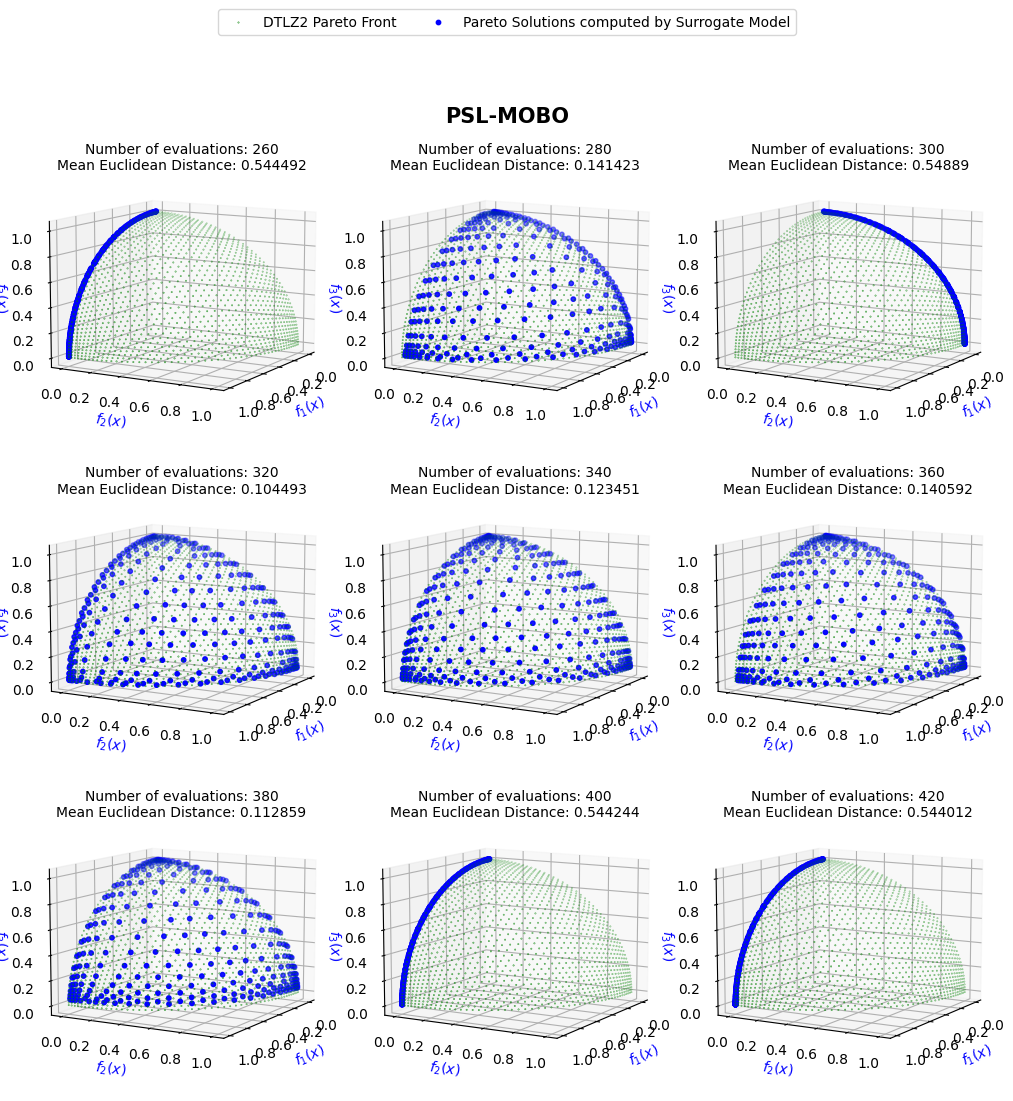

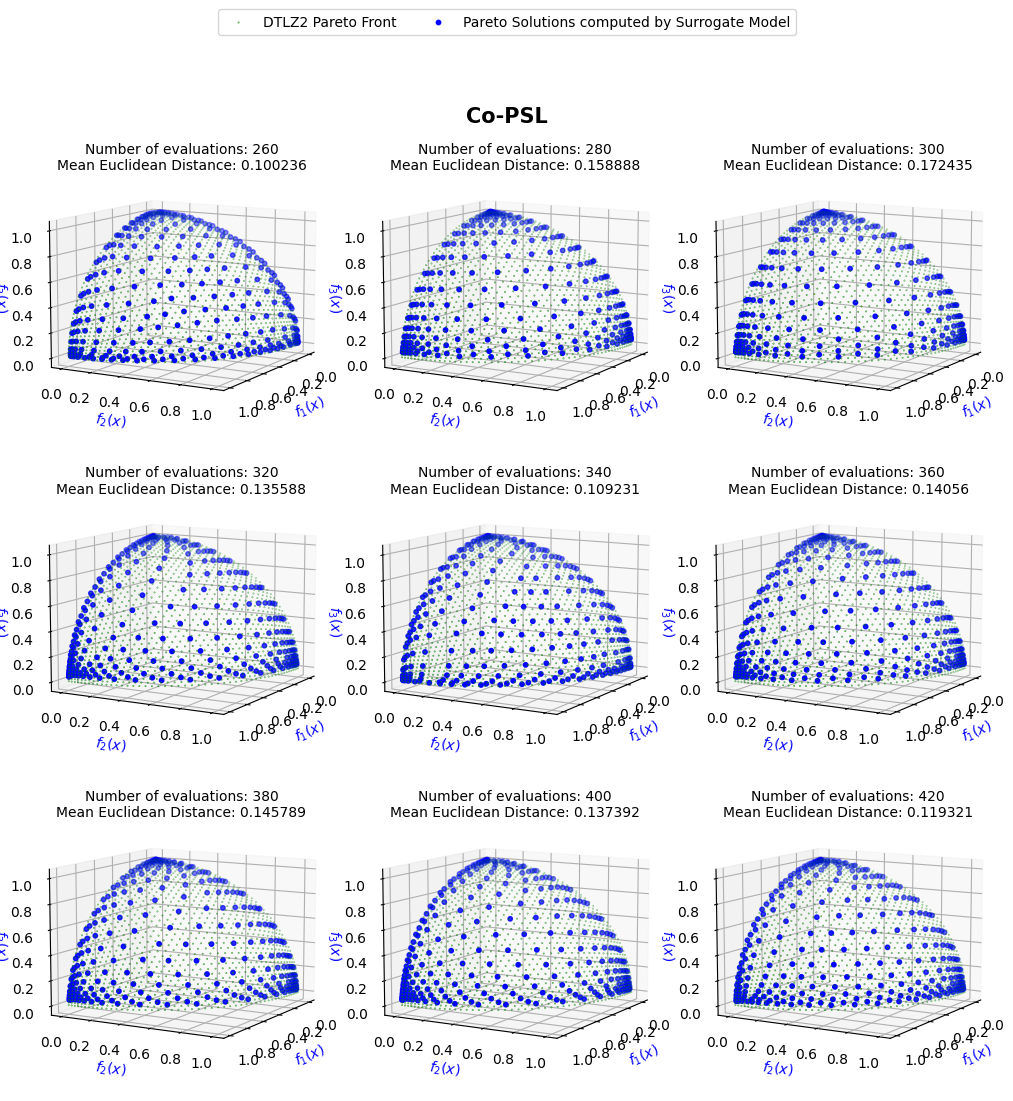

In [7]:
n_dim = 6
plot_front("DTLZ2", n_dim = n_dim, suffix="_PSL-MOBO", title = "PSL-MOBO", plot_type = 0)
plot_front("DTLZ2", n_dim, suffix="_Co-PSL", title = "Co-PSL", plot_type = 1)

/tmp/ipykernel_549429/2129903339.py:12: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=5.0)


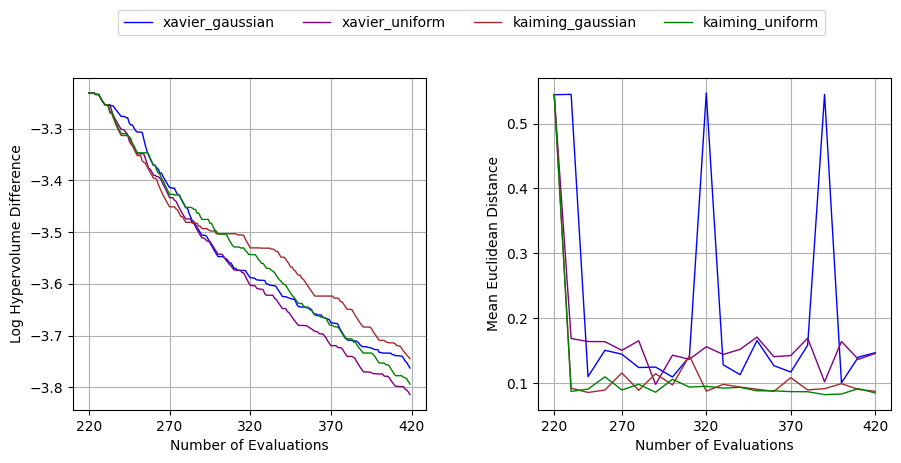

In [8]:
list_id = ['Co-PSL_xavier_gaussian', 'Co-PSL_xavier_uniform', 'Co-PSL_kaiming_gaussian', 'Co-PSL_kaiming_uniform']
label_id = ['xavier_gaussian', 'xavier_uniform', 'kaiming_gaussian', 'kaiming_uniform']
log_dir = "logs_DTLZ2"
title = "noise"
color_code = ['blue', 'purple', 'brown', 'green']
Ablation_study_DTLZ2(list_id = list_id, label_id = label_id, log_dir = log_dir, problem_name = "DTLZ2", n_dim = 6, title = title, n_iter = 20, start = 220, stop = 420, color_code = color_code)

/tmp/ipykernel_549429/2129903339.py:12: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=5.0)


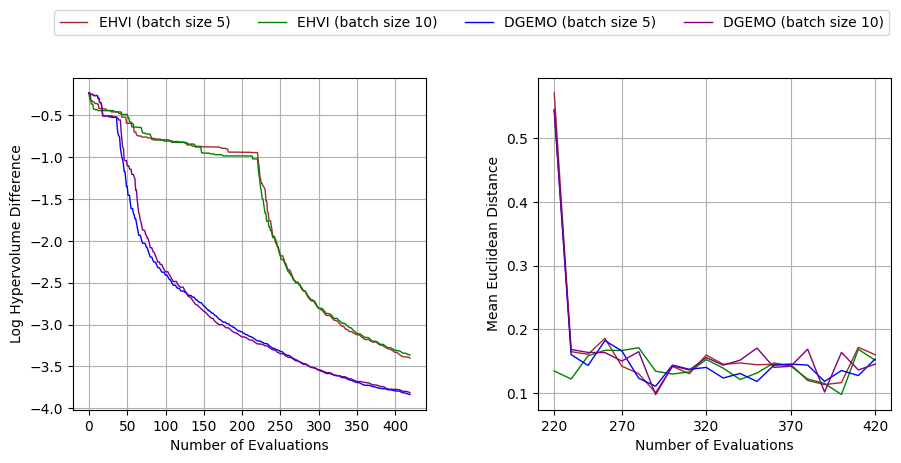

In [9]:
list_id = ['Co-PSL_EHVI_220_5', 'Co-PSL_EHVI_220_10', 'Co-PSL_DGEMO_220_5', 'Co-PSL_DGEMO_220_10']
label_id = ['EHVI (batch size 5)', 'EHVI (batch size 10)', 'DGEMO (batch size 5)', 'DGEMO (batch size 10)']
color_code = ['brown', 'green', 'blue', 'purple']
log_dir = "logs_DTLZ2"
title = "warmup"
Ablation_study_DTLZ2(list_id = list_id, label_id = label_id, log_dir = log_dir, problem_name = "DTLZ2", n_dim = 6, title = title, n_iter = 20, start = 0, stop = 420, color_code = color_code)

/tmp/ipykernel_549429/2129903339.py:12: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=5.0)


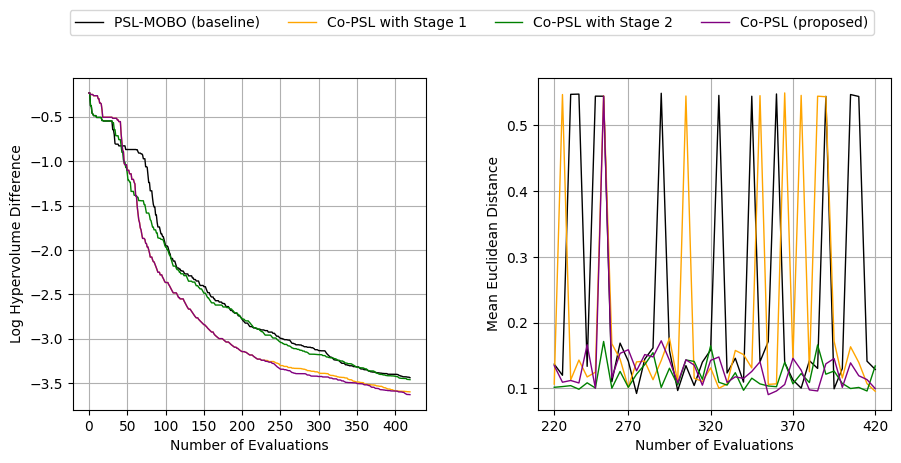

In [10]:
list_id = ['PSL-MOBO', 'stage1', 'stage2', 'Co-PSL']
label_id = ['PSL-MOBO (baseline)', 'Co-PSL with Stage 1', 'Co-PSL with Stage 2', 'Co-PSL (proposed)']
color_code = ['black', 'orange', 'green', 'purple']
log_dir = "weight/ablation_DTLZ2_PSL"
title = "final"
Ablation_study_DTLZ2(list_id = list_id, label_id = label_id, log_dir = log_dir, problem_name = "DTLZ2", n_dim = 6, title = title, n_iter = 40, start = 0, stop = 420, color_code = color_code)